In [1]:
from espei.datasets import load_datasets
from espei.error_functions.context import setup_context
from espei.error_functions.zpf_error import calculate_zpf_error
from pycalphad import Database
from glob import glob
import numpy as np

ds = load_datasets(glob('2020-05-28-Cr-Ni-ZPF/input-data/run/ZPF/*.json'))
#ds = load_datasets(['UQ/Cr-Ni-run/run/ZPF/CR-NI-ZPF-BCC_A2-FCC_A1-zhang2014impurity.json'])
dbf = Database('dft.tdb')
param_symbol_labels = {
'VV0000': 'L(A1;1)B',
'VV0001': 'L(A1;1)A',
'VV0002': 'L(A1;0)B',
'VV0003': 'L(A1;0)A',
'VV0004': 'L(A2;1)B',
'VV0005': 'L(A2;1)A',
'VV0006': 'L(A2;0)B',
'VV0007': 'L(A2;0)A',
'VV0008': 'L(LIQUID;1)B',
'VV0009': 'L(LIQUID;1)A',
'VV0010': 'L(LIQUID;0)B',
'VV0011': 'L(LIQUID;0)A'
}
dbf.elements = ['CR', 'NI', 'VA'] # workaround issue with callables of subsystem
ctx = setup_context(dbf, ds)
# weight from YAML file
ctx['zpf_kwargs']['data_weight'] = 20.0
max_phase_regions = max([len(data['phase_regions']) for data in ctx['zpf_kwargs']['zpf_data']])
print('max_phase_regions', max_phase_regions)
# shape: chain, sample, param_symbol
param_trace = np.load('2020-05-28-Cr-Ni-ZPF/trace-zpf.npy')
print('param_trace.shape', param_trace.shape)
#lnprob = np.load('UQ/Cr-Ni-run/2020-05-28-Cr-Ni-ZPF/lnprob.npy')
#lnprob_zpf = np.load('2020-05-28-Cr-Ni-ZPF/lnprob-zpf.npy')
#print('lnprob_zpf.shape', lnprob_zpf.shape)

max_phase_regions 49
param_trace.shape (24, 50, 12)


In [8]:
from tqdm.auto import tqdm
parameter_trials = []
# chain, sample, dataset, phase_region, [param_symbol]
calc_lnprob = np.zeros((param_trace.shape[0],param_trace.shape[1],len(ds), max_phase_regions))
calc_lnprobgrad = np.zeros((param_trace.shape[0],param_trace.shape[1],len(ds), max_phase_regions, param_trace.shape[2]))
#calc_lnprob = np.load('2020-06-03-zpf-lnprob.npy')
#calc_lnprobgrad = np.load('2020-06-03-zpf-lnprobgrad.npy')
chain_idx = 0
all_parameters = [np.array(param_trace[chain_idx, 0, :])]



for iter_idx in tqdm(range(50)):
    parameters = all_parameters[iter_idx]
    zpf_prob_error, zpf_prob_error_gradient = calculate_zpf_error(parameters=parameters,
                                                                  **ctx.get('zpf_kwargs'))
    calc_lnprob[chain_idx, iter_idx, :, :] = zpf_prob_error
    calc_lnprobgrad[chain_idx, iter_idx, :, :, :] = np.array(zpf_prob_error_gradient)
    ll_grad = np.sum(calc_lnprobgrad[chain_idx, iter_idx, :, :, :], axis=(0, 1))
    df_grad = -np.nansum(calc_lnprobgrad[chain_idx, iter_idx, :, :, :] / calc_lnprob[chain_idx, iter_idx, :, :, np.newaxis], axis=(0, 1))
    hess = np.outer(df_grad, df_grad)
    delta_theta = np.linalg.lstsq(hess, ll_grad, rcond=None)[0]
    #print('zpf_prob_error', zpf_prob_error)
    #print('ll_grad', ll_grad)
    #print('df_grad', df_grad)
    #print('hess', hess)
    print(iter_idx, delta_theta)
    all_parameters.append(np.array(parameters + delta_theta))

0 [-2.15630237e-01 -1.55819406e-04  2.38712145e-01  1.06718280e-04
 -1.02370051e-01 -6.48955208e-05 -3.87937099e-01 -2.60643580e-04
  1.05025907e-01  6.00800901e-05 -1.84371828e-01 -1.17301722e-04]
1 [-5.43768335e-01 -3.95573838e-04  2.03778456e-01 -7.27884029e-06
 -1.59922559e-01 -9.80170413e-05 -5.05478790e-01 -3.49055801e-04
  2.76777545e-01  1.60100337e-04 -4.63710598e-01 -2.90540007e-04]
2 [-8.02708592e-02 -5.90516531e-05 -2.11517863e-01 -1.63634923e-04
  9.19067641e-03  7.25845833e-06  1.56235782e-01  1.00003870e-04
  3.90373329e-02  2.27001142e-05 -3.18029643e-02 -1.90058243e-05]
3 [-4.94563539e-01 -3.57355516e-04 -3.36182556e-01 -3.48802995e-04
 -7.81303843e-02 -4.28792391e-05 -2.02210789e-01 -1.38712743e-04
  2.96385961e-01  1.73563705e-04 -4.67500431e-02 -2.84356550e-05]
4 [-3.66981255e-01 -2.63241921e-04  1.65411608e-02 -9.01498526e-05
  2.50820740e-02  1.60012144e-05  8.06662629e-02  3.55777264e-05
  1.33006852e-01  7.88382963e-05 -5.12601271e-01 -3.10438537e-04]
5 [-9.7373

Text(0, 0.5, 'lnprob')

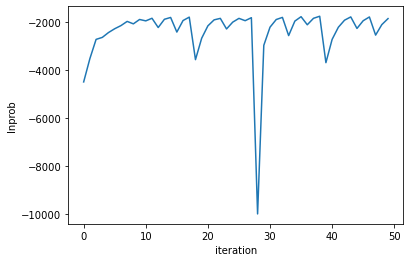

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.arange(50), calc_lnprob[chain_idx, :, :].sum(axis=(-2, -1)))
plt.xlabel('iteration')
plt.ylabel('lnprob')

Text(0.5, 1.0, 'Cr-Ni Newton Trial 0')

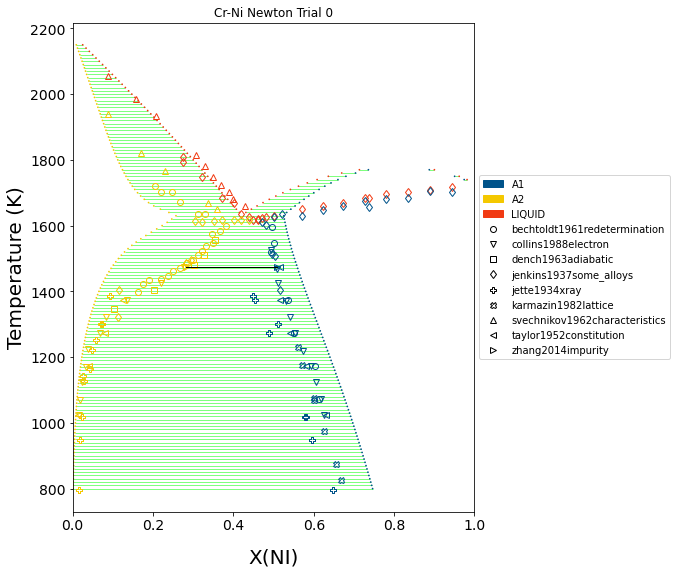

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from espei.plot import dataplot
from pycalphad import variables as v
from pycalphad import binplot
from pycalphad.core.solver import InteriorPointSolver, SundmanSolver

fig = plt.figure(figsize=(9,9))
ax = fig.gca()
trial_idx = 0
binplot(dbf, ['CR', 'NI', 'VA'], ['A1','A2', 'LIQUID'], {v.P: 101325, v.T: (800, 2200, 10), v.X('NI'): (0,1,0.02), v.N:1},
        plot_kwargs={'ax': ax},
        eq_kwargs={'solver': SundmanSolver(),
                   'parameters': dict(zip(ctx['symbols_to_fit'], all_parameters[trial_idx]))})
dataplot(['CR', 'NI', 'VA'], ['A1', 'A2', 'LIQUID'], {v.P: 101325, v.T: (1,1,1), v.X('NI'): (1, 1, 1)}, ds, ax=ax)
ax.set_title(f'Cr-Ni Newton Trial {trial_idx}')

Text(0.5, 1.0, 'Cr-Ni Newton Trial 49')

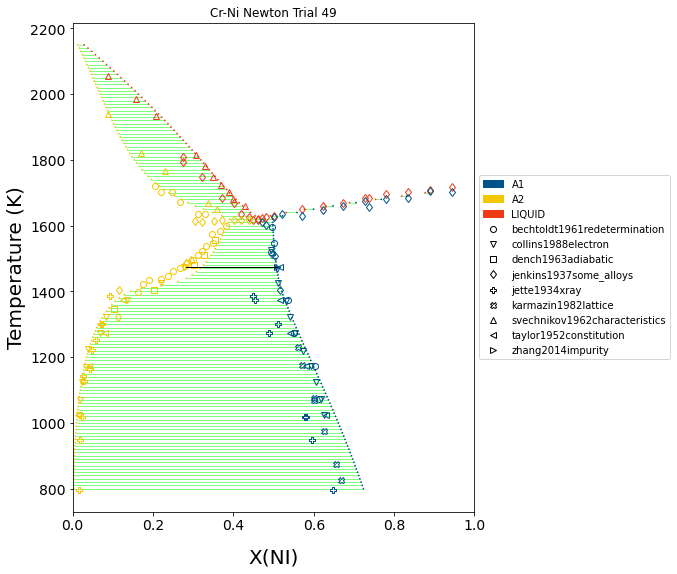

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from espei.plot import dataplot
from pycalphad import variables as v
from pycalphad import binplot
from pycalphad.core.solver import InteriorPointSolver, SundmanSolver

fig = plt.figure(figsize=(9,9))
ax = fig.gca()
trial_idx = 49
binplot(dbf, ['CR', 'NI', 'VA'], ['A1','A2', 'LIQUID'], {v.P: 101325, v.T: (800, 2200, 10), v.X('NI'): (0,1,0.02), v.N:1},
        plot_kwargs={'ax': ax},
        eq_kwargs={'solver': SundmanSolver(),
                   'parameters': dict(zip(ctx['symbols_to_fit'], all_parameters[trial_idx]))})
dataplot(['CR', 'NI', 'VA'], ['A1', 'A2', 'LIQUID'], {v.P: 101325, v.T: (1,1,1), v.X('NI'): (1, 1, 1)}, ds, ax=ax)
ax.set_title(f'Cr-Ni Newton Trial {trial_idx}')

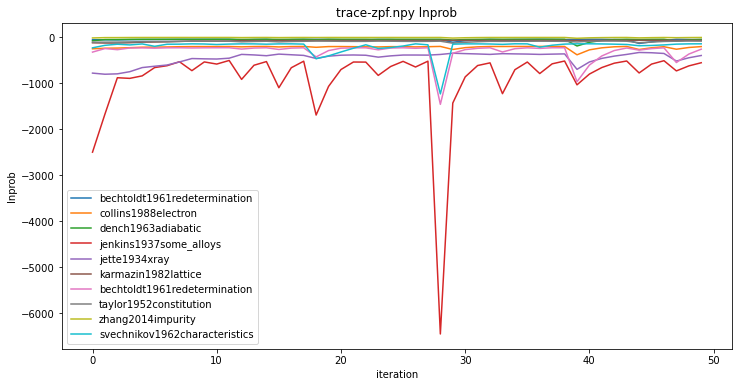

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprob = np.sum(calc_lnprob[:, :, data_idx, :], axis=-1)
    avg_calc_lnprob = data_calc_lnprob[chain_idx]
    std_calc_lnprob = np.std(data_calc_lnprob, axis=0)
    ax.plot(np.arange(50), avg_calc_lnprob, label=dataset['dataset_reference'])
    #ax.fill_between(np.arange(50), avg_calc_lnprob+std_calc_lnprob, avg_calc_lnprob-std_calc_lnprob, alpha=0.1)
ax.set_xlabel('iteration')
ax.set_ylabel('lnprob')
ax.set_title('trace-zpf.npy lnprob')
ax.legend()

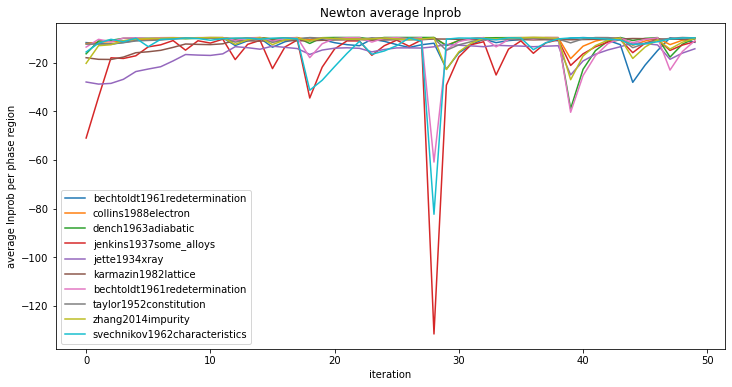

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprob = np.sum(calc_lnprob[:, :, data_idx, :], axis=-1)
    avg_calc_lnprob = data_calc_lnprob[chain_idx]
    std_calc_lnprob = np.std(data_calc_lnprob, axis=0)
    num_phase_regions = len(dataset['phase_regions'])
    ax.plot(np.arange(50), avg_calc_lnprob / num_phase_regions, label=dataset['dataset_reference'])
    #ax.fill_between(np.arange(50), (avg_calc_lnprob+std_calc_lnprob) / num_phase_regions,
    #                               (avg_calc_lnprob-std_calc_lnprob) / num_phase_regions, alpha=0.1)
ax.set_xlabel('iteration')
ax.set_ylabel('average lnprob per phase region')
ax.set_title('Newton average lnprob')
ax.legend()

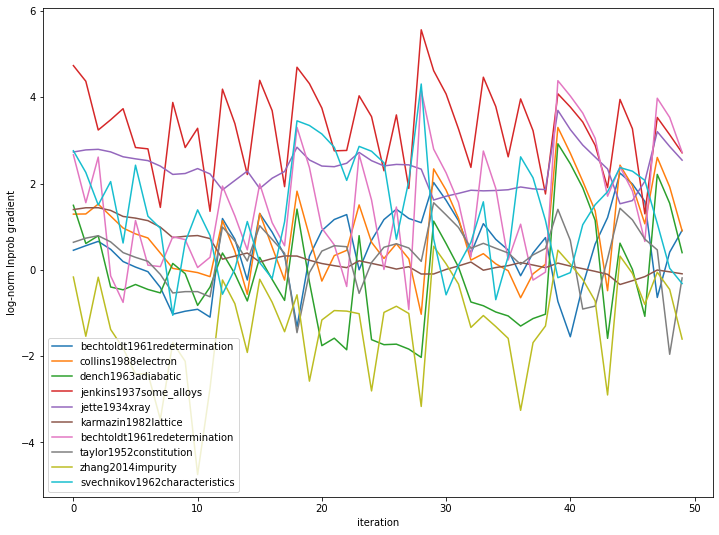

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,9))
ax = fig.gca()
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    mean_calc_lnprobgrad = np.mean(data_calc_lnprobgrad, axis=0)
    ax.plot(np.arange(50), np.log(np.linalg.norm(mean_calc_lnprobgrad, axis=-1)), label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('log-norm lnprob gradient')
ax.legend()

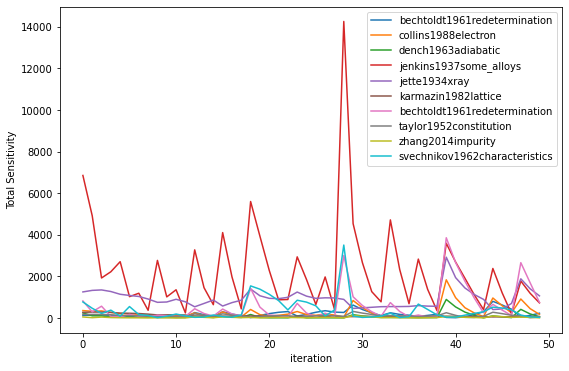

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
trace_param_std = np.std(param_trace[:, :, :], axis=(0, 1))
tdbdb_param_std = 0 # TODO
# Averaging Scheme No. 1 -- what other possibilities?
for data_idx, dataset in enumerate(ctx['zpf_kwargs']['zpf_data']):
    data_calc_lnprobgrad = np.sum(calc_lnprobgrad[:, :, data_idx, :, :], axis=-2)
    mean_calc_lnprobgrad = data_calc_lnprobgrad[chain_idx]
    ax.plot(np.arange(50), np.abs(mean_calc_lnprobgrad).dot(trace_param_std), label=dataset['dataset_reference'])
ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity')
ax.legend()

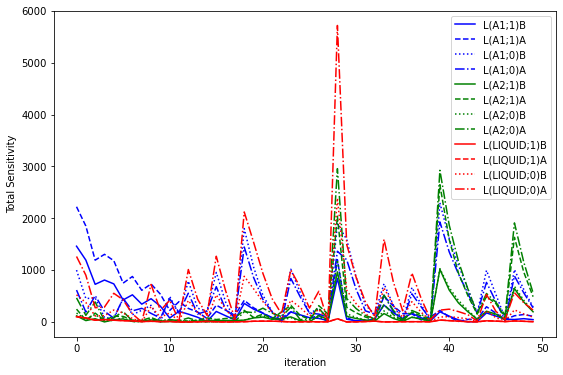

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from cycler import cycler

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
custom_cycler = (cycler(color='bgrcmyk') *
                 cycler(linestyle=['-', '--', ':', '-.']))
ax.set_prop_cycle(custom_cycler)
trace_param_std = np.std(param_trace[:, :, :], axis=(0,1))
tdbdb_param_std = 0 # TODO
total_calc_lnprobgrad = np.sum(calc_lnprobgrad[0, :, :, :, :], axis=(1, 2))
total_calc_sensitivity = total_calc_lnprobgrad * trace_param_std
for param_idx, param_symbol in enumerate(ctx['symbols_to_fit']):
    ax.plot(np.arange(50), np.abs(total_calc_sensitivity[:, param_idx]), label=param_symbol_labels[param_symbol])

ax.set_xlabel('iteration')
ax.set_ylabel('Total Sensitivity')
ax.legend()